In [137]:
import gym 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
from collections import deque
import random
import math
import time
import copy

In [2]:
env = gym.make('Pendulum-v0')

In [3]:
state = env.reset()
while True:
    action = env.action_space.sample()
    state,reward,done,_ = env.step(action)
    env.render()
    if done:
        break


In [4]:
print(env.action_space)
print(env.observation_space)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print("State size : ",state_size," Action Size: ",action_size)

Box(1,)
Box(3,)
State size :  3  Action Size:  1


In [12]:
state = env.reset()
state.shape

(3,)

In [13]:
state = torch.FloatTensor(state).unsqueeze(0)
state.shape

torch.Size([1, 3])

In [203]:
class Actor(nn.Module):
    def __init__(self,input_size,output_size):
        super(Actor,self).__init__()
        
        self.actor = nn.Sequential(nn.Linear(input_size,512),
                                  nn.ReLU(),
                                  nn.Linear(512,256),
                                  nn.ReLU(),
                                  nn.Linear(256,output_size),
                                  nn.Tanh())
    def forward(self,state):
        ac = self.actor(state)
        return ac

In [204]:
class Critic(nn.Module):
    def __init__(self,input_size):
        super(Critic, self).__init__()
        
        self.fcs1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32+action_size, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self,state,action):
        
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Agent

In [205]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [206]:
class Agent():
    def __init__(self,input_size,output_size):
        
        
        self.buffer_size = int(1e6)
        self.actor_lr = 1e-4
        self.critic_lr = 1e-3
        self.tau = 0.001
        self.batch_size = 64
        self.gamma = 0.99
        
        self.actor_local = Actor(input_size,output_size)
        self.actor_target = Actor(input_size,output_size)
        
        self.critic_local = Critic(input_size)
        self.critic_target = Critic(input_size)
        
        self.memory = deque(maxlen=self.buffer_size)
        self.noise = OUNoise(action_size)
        
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),lr=self.actor_lr)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),lr=self.critic_lr)
        
        self.ac_loss = []
        self.cr_loss = []
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    def act(self,state,add_noise=True):
        #state = torch.FloatTensor(state).unsqueeze(0)
        state = torch.from_numpy(state).float()
        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).detach().numpy()
        if add_noise:
            action+=self.noise.sample()
        
        return np.clip(action,-1,1)
    def reset(self):
        self.noise.reset()
    
    def step(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))
        
        if len(self.memory) > self.batch_size:
            self.train()
    def sample(self):
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.int8)).float().to(device)
        
        return states,actions,rewards,next_states,dones
    
    def train(self):
        
        states,actions,rewards,next_states,dones = self.sample()
        
        action_target = self.actor_target(next_states)
        y = rewards + self.gamma*self.critic_target(next_states,action_target)*(1-dones)
        
        Q_expected = self.critic_local(states,actions)
        critic_loss = F.mse_loss(Q_expected,y)
        self.cr_loss.append(critic_loss.item())
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states,actions_pred).mean()
        self.ac_loss.append(actor_loss.item())
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.soft_update(self.actor_target,self.actor_local,self.tau)
        self.soft_update(self.critic_target,self.critic_local,self.tau)
    def soft_update(self,target_model,local_model,tau):
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [207]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Implementing the DDPG Algorithm

In [208]:
agent = Agent(state_size,action_size)

In [ ]:
n_episodes = 1000
reward_per_ep = []
avg_last_100 = []
for ep in range(1,n_episodes+1):
    state = env.reset()
    state = state.reshape(1,3)
    score = 0
    while True:
        action = agent.act(state)
        next_state,reward,done,_ = env.step(action)
        score+=reward[0]
        next_state = next_state.reshape(1,3)
        agent.step(state,action,reward,next_state,done)
        state = next_state
        if done:
            break
    
    reward_per_ep.append(score)
    print("\rEpisode ",ep," , Score : ",score,"  ",end="")
    if ep > 100 :
        avg = np.mean(reward_per_ep[-100:])
        avg_last_100.append(avg)
        print("  Avg. of last 100 : {:3f}".format(avg),end="")

Episode  926  , Score :  -1286.3033150434494     Avg. of last 100 : -1178.410838

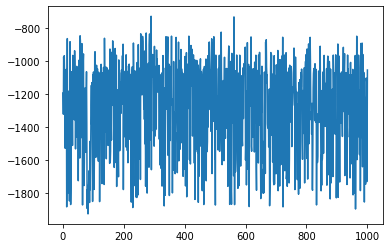

In [201]:
import matplotlib.pyplot as plt
x = np.arange(len(reward_per_ep))+1
plt.plot(x,reward_per_ep,label='Scores')
#plt.plot(x+64,agent.ac_loss,'Actor Loss')
plt.show()

In [202]:
agent.ac_loss

[-0.04809209704399109,
 -0.024385599419474602,
 0.007157747633755207,
 0.044800207018852234,
 0.06856711208820343,
 0.095770925283432,
 0.13146106898784637,
 0.17397159337997437,
 0.1918778270483017,
 0.227634459733963,
 0.2625759243965149,
 0.2908536195755005,
 0.32575324177742004,
 0.3869571387767792,
 0.3852877616882324,
 0.46551570296287537,
 0.4651067852973938,
 0.5588158965110779,
 0.5597869157791138,
 0.6264790296554565,
 0.6770148277282715,
 0.748593807220459,
 0.7864305377006531,
 0.8723883032798767,
 0.8796416521072388,
 0.9629263877868652,
 1.003523826599121,
 1.0519903898239136,
 1.1125544309616089,
 1.1581157445907593,
 1.222915768623352,
 1.3855947256088257,
 1.36353600025177,
 1.4096260070800781,
 1.4088220596313477,
 1.530741810798645,
 1.7461984157562256,
 1.795824408531189,
 1.7638936042785645,
 2.0004959106445312,
 1.943443775177002,
 2.2194480895996094,
 2.2195920944213867,
 2.285982608795166,
 2.469167709350586,
 2.4498279094696045,
 2.4802114963531494,
 2.70613145